In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

## Stock level


In [2]:
# raw option return data
raw = pd.read_parquet(r"C:\Users\Mathiass\OneDrive - Universität Zürich UZH\Documents\mt_literature\data\old\intermediate_data\sp500_call_cao_nadropped.parquet")

In [3]:
# raw

In [4]:
small = pd.read_parquet(r"C:\Users\Mathiass\Documents\Projects\master-thesis\data\final_df_call_cao_small.parquet")

In [5]:
small["impl_volatility"].describe()

count    766524.000000
mean          0.371724
std           0.182217
min           0.013138
25%           0.251836
50%           0.326909
75%           0.436513
max           2.930194
Name: impl_volatility, dtype: float64

In [6]:
small[["date", "impl_volatility", "option_ret"]].sort_values(by="option_ret")[:10]

,date,impl_volatility,option_ret
690876,2020-12-31,1.237770,-46.160174
690875,2020-12-31,1.186219,-39.889260
690874,2020-12-31,1.090725,-32.879258
690873,2020-12-31,1.169715,-25.509772
690872,2020-12-31,1.114575,-23.839101
690871,2020-12-31,1.093854,-17.172514
282698,2009-07-31,0.874029,-13.090098
282699,2009-07-31,0.935266,-10.842894
282697,2009-07-31,0.869903,-7.171504
687041,2020-12-31,0.872844,-7.010967


In [7]:
# Multiclass y label generator.
def multi_categorize(y: float, classes: int):
    """
    Creates categorical labels from continuous values.

        Args:
            y (float):      continuous target variable (option return)
            classes (int):  number of classes to create
        Returns:
            (int):          class assignment
        CAREFUL: classes have to be between [0, C) for F.crossentropyloss.
    """
    if classes == 3:
        # thresholds: +/- 5%
        if y > 0.05:
            return 2
        elif y < -0.05:
            return 0
        else:
            return 1
    elif classes == 5:
        # thresholds: +/- 2.5% and +/- 5%
        if y > 0.05:
            return 4
        elif (y > 0.025 and y <= 0.05):
            return 3
        elif (y >= -0.05 and y < -0.025):
            return 1
        elif (y < -0.05):
            return 0
        else:
            return 2 # all returns \elin [-0.025, 0.025]
    # elif classes==10:
    #     if y > 0.05:
    #         return 9
    #     elif (y > 0.04 and y <= 0.05):
    #         return 8
    #     elif (y > 0.03 and y <= 0.04):
    #         return 7
    #     elif (y > 0.02 and y <= 0.03):
    #         return 6
    #     elif (y > 0.01 and y <= 0.02):
    #         return 5
    #     elif (y >= -0.02 and y < -0.01):
    #         return 3
    #     elif (y >= -0.03 and y < -0.02):
    #         return 2
    #     elif (y >= -0.04 and y < -0.03):
    #         return 1
    #     elif (y >= -0.05 and y < -0.05):
    #         return 0
    #     else:
    #         return 4
    else:
        raise ValueError("Only multi for 3 or 5 classes implemented right now.")

In [8]:
def load_data(path_data: Path, dataset: str):
    """Loads specific dataset from path, depending on specified size."""
    if dataset == "small":
        return pd.read_parquet(path_data/"final_df_call_cao_small.parquet")
    elif dataset == "medium":
        return pd.read_parquet(path_data/"final_df_call_cao_med_fillmean.parquet")
    elif dataset == "big":
        return pd.read_parquet(path_data/"final_df_call_cao_big_fillmean.parquet")
    else:
        raise ValueError("Specify dataset as either 'small', 'medium' or big'")

In [9]:
def get_exp_path(expid):
    logs_folder = Path(r"C:\Users\Mathiass\Documents\Projects\master-thesis")/"logs"
    matches = Path(logs_folder).rglob(expid) #Get folder in logs_folder that matches expid
    matches_list = list(matches)
    if not len(matches_list) == 1:
        raise ValueError(f"There exists none or more than 1 folder with "
                            f"experiment id {expid} in the {logs_folder.name} "
                            "directory!")
    exp_dir = matches_list[0]
    return exp_dir

In [10]:
def show_best_worst_pred(exp_id, top_bot=10):
    exp_dir = get_exp_path(str(exp_id))
    # Read args.json
    args_exp = pd.read_json(exp_dir/"args.json", typ="series")
    # Data path
    path_data = Path(r"C:\Users\Mathiass\Documents\Projects\master-thesis\data")
    dataset = load_data(path_data, args_exp.dataset)
    # Read all preds.
    all_pred = pd.read_csv(exp_dir/"all_pred.csv")
    preds = all_pred["pred"]
    # Align dataset with preds.
    data_test = dataset.iloc[-len(all_pred):].reset_index(drop=False)
    # Get true labels.
    y_true = data_test["option_ret"].apply(multi_categorize, classes=5).rename("y_true").reset_index(drop=True)
    # Concat dataset, the true label and the preds.
    concat = pd.concat([data_test, y_true, preds], axis=1)
    best_indeces = list(dataset["option_ret"].sort_values(ascending=False).head(top_bot).index)
    worst_indeces = list(dataset["option_ret"].sort_values().head(top_bot).index)
    best_worst_indeces = best_indeces + worst_indeces
    return concat[concat["index"].isin(best_worst_indeces)]

In [11]:
show_best_worst_pred(20220924104656)

,index,date,moneyness,ba_spread_option,volume,open_interest,impl_volatility,delta,gamma,vega,...,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,option_ret,y_true,pred
25805,260536,2008-09-30,2.285714,0.266667,123,396,2.090692,0.587635,0.002488,0.281928,...,0.211714,4.666127e-10,0.286765,0.187515,0.760798,117.751795,1.092553e-09,2.598716,4,4
25806,260537,2008-09-30,1.714286,0.421053,10,127,2.067678,0.652817,0.002379,0.267125,...,0.211714,4.666127e-10,0.286765,0.187515,0.760798,117.751795,1.092553e-09,2.727052,4,4
47966,282697,2009-07-31,2.283105,0.166667,1,82,0.869903,0.172901,0.003944,0.190908,...,0.122561,1.998076e-10,0.241056,0.117457,0.910032,57.233761,4.614548e-10,-7.171504,0,4
47967,282698,2009-07-31,2.663623,0.241379,1,360,0.874029,0.088313,0.002701,0.108686,...,0.122561,1.998076e-10,0.241056,0.117457,0.910032,57.233761,4.614548e-10,-13.090098,0,4
47968,282699,2009-07-31,3.424658,0.300000,1,269,0.935266,0.079065,0.002113,0.109835,...,0.122561,1.998076e-10,0.241056,0.117457,0.910032,57.233761,4.614548e-10,-10.842894,0,4
394777,629508,2020-03-31,23.916293,0.666667,21,1408,2.860694,0.421645,0.001430,0.313339,...,0.264401,2.152456e-08,0.613811,0.219876,0.748416,22.322640,1.816957e-09,5.475154,4,0
395504,630235,2020-03-31,1.515152,0.930233,3,187,2.555623,0.765599,0.001620,0.226654,...,0.233042,7.762491e-09,0.392694,0.191935,0.542743,49.763480,9.389655e-10,3.190737,4,4
395505,630236,2020-03-31,5.050505,0.571429,56,6217,1.830411,0.431096,0.002409,0.350416,...,0.233042,7.762491e-09,0.392694,0.191935,0.542743,49.763480,9.389655e-10,3.031025,4,4
395506,630237,2020-03-31,1.515152,0.269231,10,1599,2.070703,0.757857,0.001686,0.278532,...,0.233042,7.762491e-09,0.392694,0.191935,0.542743,49.763480,9.389655e-10,2.732855,4,4
395507,630238,2020-03-31,2.525253,0.176471,2,55749,1.838188,0.601241,0.002353,0.344229,...,0.233042,7.762491e-09,0.392694,0.191935,0.542743,49.763480,9.389655e-10,2.649085,4,4


In [12]:
from sklearn.metrics import ConfusionMatrixDisplay

In [13]:
def get_confus(exp_id):
    exp_dir = get_exp_path(str(exp_id))
    # Read args.json
    args_exp = pd.read_json(exp_dir/"args.json", typ="series")
    # Data path
    path_data = Path(r"C:\Users\Mathiass\Documents\Projects\master-thesis\data")
    dataset = load_data(path_data, args_exp.dataset)
    # Read all preds.
    all_pred = pd.read_csv(exp_dir/"all_pred.csv")
    preds = all_pred["pred"]
    # Align dataset with preds.
    data_test = dataset.iloc[-len(all_pred):].reset_index(drop=False)
    # Get true labels.
    y_true = data_test["option_ret"].apply(multi_categorize, classes=5).rename("y_true").reset_index(drop=True)
    
    return ConfusionMatrixDisplay.from_predictions(y_true, preds, normalize=None), confusion_matrix(y_true, preds).sum(axis=1)

(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x2002eec8760>,
 array([ 52403,  37814, 298905,  82837,  59834], dtype=int64))

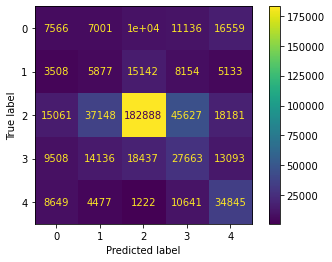

In [14]:
get_confus(20220923074741)

In [15]:
sum([ 20122,  45726, 229039, 120360, 116546])

531793

In [16]:
def count_preds(exp_id):
    exp_dir = get_exp_path(str(exp_id))
    # Read args.json
    args_exp = pd.read_json(exp_dir/"args.json", typ="series")
    # Data path
    path_data = Path(r"C:\Users\Mathiass\Documents\Projects\master-thesis\data")
    dataset = load_data(path_data, args_exp.dataset)
    # Read all preds.
    all_pred = pd.read_csv(exp_dir/"all_pred.csv")
    preds = all_pred["pred"]
    # Align dataset with preds.
    data_test = dataset.iloc[-len(all_pred):].reset_index(drop=False)
    # Get true labels.
    y_true = data_test["option_ret"].apply(multi_categorize, classes=5).rename("y_true").reset_index(drop=True)
    
    print("Pred value counts:", preds.value_counts(), sep="\n")
    print("---")
    print("Y true value counts:", y_true.value_counts(), sep="\n")

In [17]:
count_preds(20220908133630)

Pred value counts:
2    211538
3    149547
4    120089
1     25700
0     24919
Name: pred, dtype: int64
---
Y true value counts:
2    298905
3     82837
4     59834
0     52403
1     37814
Name: y_true, dtype: int64


In [18]:
# confusion_matrix(y_true, preds)[:, 0].sum()

In [19]:
# confusion_matrix(y_true, preds)

In [20]:
def describe_classes(exp_id):
    exp_dir = get_exp_path(str(exp_id))
    # Read args.json
    args_exp = pd.read_json(exp_dir/"args.json", typ="series")
    # Data path
    path_data = Path(r"C:\Users\Mathiass\Documents\Projects\master-thesis\data")
    dataset = load_data(path_data, args_exp.dataset)
    # Read all preds.
    all_pred = pd.read_csv(exp_dir/"all_pred.csv")
    preds = all_pred["pred"]
    # Align dataset with preds.
    data_test = dataset.iloc[-len(all_pred):].reset_index(drop=False)
    # Get true labels.
    y_true = data_test["option_ret"].apply(multi_categorize, classes=5).rename("y_true").reset_index(drop=True)
    
    #portfolios folder
    pfs = []
    portfolios_path = exp_dir/"portfolios"
    for file in portfolios_path.iterdir():
        pf = pd.read_csv(file)
        pfs.append(pf["option_ret"].rename(file.name[:-4]))
    
#     out = pd.concat(pfs, axis=1).describe()
    out = pd.concat(pfs, axis=1)
    
    return out
    
    

In [21]:
test = describe_classes(20220908133630)

In [22]:
len(test["class0"])

166

## Portfolio Level

In [23]:
path = Path(r"C:\Users\Mathiass\Documents\Projects\master-thesis\logs\production\medium\xgb\20220924104656\portfolios")

In [24]:
cols =["date", "option_ret", "pred"]

In [25]:
ls3 = pd.read_csv(path/"long3short0.csv")[cols]
ls4 = pd.read_csv(path/"long4short0.csv")[cols]
ls5 = pd.read_csv(path/"long3short1.csv")[cols]

In [26]:
ls3

,date,option_ret,pred
0,2008-01-31,0.042431,3.0
1,2008-02-29,0.020134,3.0
2,2008-03-31,0.007482,3.0
3,2008-04-30,0.076380,3.0
4,2008-05-31,0.012029,3.0
...,...,...,...
161,2021-06-30,0.017637,3.0
162,2021-07-31,-0.002346,3.0
163,2021-08-31,0.004380,3.0
164,2021-09-30,0.020247,3.0


<AxesSubplot:>

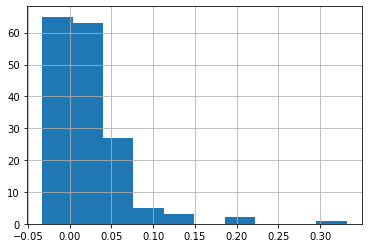

In [27]:
ls3["option_ret"].hist()

<AxesSubplot:>

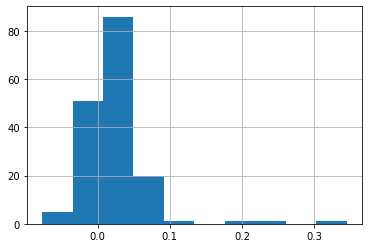

In [28]:
ls4["option_ret"].hist()

<AxesSubplot:>

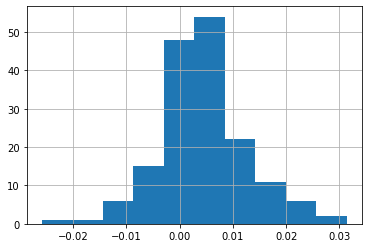

In [29]:
ls5["option_ret"].hist()

In [30]:
ls4.sort_values(by="option_ret", ascending=False)[:20]

,date,option_ret,pred
6,2008-07-31,0.344718,4.0
70,2013-11-30,0.236164,4.0
105,2016-10-31,0.205319,4.0
63,2013-04-30,0.120238,4.0
33,2010-10-31,0.084713,4.0
119,2017-12-31,0.082988,4.0
3,2008-04-30,0.073340,4.0
101,2016-06-30,0.071998,4.0
5,2008-06-30,0.071581,4.0
88,2015-05-31,0.071218,4.0


In [31]:
# Add cumulative return column
ls4["option_ret_cum"] = (ls4["option_ret"] + 1).cumprod()

In [32]:
ls4[ls4["date"] > "2013"][:30]

,date,option_ret,pred,option_ret_cum
60,2013-01-31,-0.015013,4.0,2.566425
61,2013-02-28,0.013957,4.0,2.602244
62,2013-03-31,0.010491,4.0,2.629544
63,2013-04-30,0.120238,4.0,2.945716
64,2013-05-31,0.039695,4.0,3.062645
65,2013-06-30,0.000000,0.0,3.062645
66,2013-07-31,0.068170,4.0,3.271426
67,2013-08-31,0.035071,4.0,3.386156
68,2013-09-30,0.070734,4.0,3.625674
69,2013-10-31,0.019908,4.0,3.697853


In [33]:
ls3.sort_values(by="option_ret", ascending=False)[:20]

,date,option_ret,pred
6,2008-07-31,0.331576,3.0
105,2016-10-31,0.220572,3.0
70,2013-11-30,0.218211,3.0
63,2013-04-30,0.147727,3.0
119,2017-12-31,0.120082,3.0
62,2013-03-31,0.114693,3.0
33,2010-10-31,0.090236,3.0
134,2019-03-31,0.090127,3.0
5,2008-06-30,0.081964,3.0
155,2020-12-31,0.077308,3.0


In [34]:
def get_month_class(exp_id, month, pred=0, cols=["date", "option_ret", "y_true", "pred", "secid"]):
    exp_dir = get_exp_path(str(exp_id))
    # Read args.json
    args_exp = pd.read_json(exp_dir/"args.json", typ="series")
    # Data path
    path_data = Path(r"C:\Users\Mathiass\Documents\Projects\master-thesis\data")
    dataset = load_data(path_data, args_exp.dataset)
    # Read all preds.
    all_pred = pd.read_csv(exp_dir/"all_pred.csv")
    preds = all_pred["pred"]
    # Align dataset with preds.
    data_test = dataset.iloc[-len(all_pred):].reset_index(drop=False)
    # Read secid
    secid = pd.read_csv(path_data/"secid.csv", index_col=0)
    secid = secid.iloc[-len(all_pred):].reset_index(drop=True)
    # Get true labels.
    y_true = data_test["option_ret"].apply(multi_categorize, classes=5).rename("y_true").reset_index(drop=True)
    # Concat dataset, the true label and the preds.
    concat = pd.concat([data_test, secid, y_true, preds], axis=1)
    # Filter for month
    concat_month = concat[concat["date"]==month]
    # Filter for pred class
    concat_month = concat_month[concat_month["pred"] == pred]
    return concat_month[cols]

In [35]:
len(get_month_class(20220924104656, "31.05.2014").sort_values(by="option_ret")["secid"].unique())

C:\Users\Mathiass\Anaconda3\envs\masterthesis\lib\site-packages\pandas\core\arraylike.py:40: UserWarning: Parsing '31.05.2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.eq)


27

### Worst returns

####  Worst return is gamestop share

#### Secid 113993 = Gamestop
#### Secid 101397 = AIG

In [36]:
small[["date", "option_ret"]].sort_values(by="option_ret")[:15]

,date,option_ret
690876,2020-12-31,-46.160174
690875,2020-12-31,-39.889260
690874,2020-12-31,-32.879258
690873,2020-12-31,-25.509772
690872,2020-12-31,-23.839101
690871,2020-12-31,-17.172514
282698,2009-07-31,-13.090098
282699,2009-07-31,-10.842894
282697,2009-07-31,-7.171504
687041,2020-12-31,-7.010967


#### RAW dataset to see to which stock these options belong to...

In [37]:
#Top 10 worst returns, see above 113993 = Gamestop, 101397 = AIG.
worst = raw.loc[raw["OPT_RET"].sort_values()[:15].index, ["date", "OPT_RET", "optionid", "secid", "cp_flag"]]
worst

,date,OPT_RET,optionid,secid,cp_flag
3427670,2020-12-31,-46.160174,137759524,113993,C
3427669,2020-12-31,-39.889260,137262832,113993,C
3412386,2020-12-31,-32.879258,137671995,113993,C
3412385,2020-12-31,-25.509772,137350285,113993,C
3412384,2020-12-31,-23.839101,137350284,113993,C
3412381,2020-12-31,-17.172514,137350281,113993,C
1219391,2009-07-31,-13.090098,46033764,101397,C
1219392,2009-07-31,-10.842894,46718132,101397,C
1219373,2009-07-31,-7.171504,46404841,101397,C
3419480,2020-12-31,-7.010967,137430985,102068,C


## Find companies that map to secid

In [38]:
def find_co(df):
    mapp = pd.read_csv(r"C:\Users\Mathiass\OneDrive - Universität Zürich UZH\Documents\mt_literature\data\mapping_table.csv")
    df = pd.merge(df, mapp, on="secid", how="left")
    const = pd.read_csv(r"C:\Users\Mathiass\OneDrive - Universität Zürich UZH\Documents\mt_literature\data\sp500_const_list.csv")
    df = pd.merge(df, const, on="permno", how="left")
    return df

In [39]:
find_co(worst)

,date,OPT_RET,optionid,secid,cp_flag,sdate,edate,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending
0,2020-12-31,-46.160174,137759524,113993,C,13/02/2002 00:00,31/12/2020 00:00,89301,GAMESTOP CORP NEW,36467W10,11.0,1.0,5734.0,GME,145049.0,01,2007-12-14 00:00:00,2016-04-22 00:00:00
1,2020-12-31,-39.889260,137262832,113993,C,13/02/2002 00:00,31/12/2020 00:00,89301,GAMESTOP CORP NEW,36467W10,11.0,1.0,5734.0,GME,145049.0,01,2007-12-14 00:00:00,2016-04-22 00:00:00
2,2020-12-31,-32.879258,137671995,113993,C,13/02/2002 00:00,31/12/2020 00:00,89301,GAMESTOP CORP NEW,36467W10,11.0,1.0,5734.0,GME,145049.0,01,2007-12-14 00:00:00,2016-04-22 00:00:00
3,2020-12-31,-25.509772,137350285,113993,C,13/02/2002 00:00,31/12/2020 00:00,89301,GAMESTOP CORP NEW,36467W10,11.0,1.0,5734.0,GME,145049.0,01,2007-12-14 00:00:00,2016-04-22 00:00:00
4,2020-12-31,-23.839101,137350284,113993,C,13/02/2002 00:00,31/12/2020 00:00,89301,GAMESTOP CORP NEW,36467W10,11.0,1.0,5734.0,GME,145049.0,01,2007-12-14 00:00:00,2016-04-22 00:00:00
5,2020-12-31,-17.172514,137350281,113993,C,13/02/2002 00:00,31/12/2020 00:00,89301,GAMESTOP CORP NEW,36467W10,11.0,1.0,5734.0,GME,145049.0,01,2007-12-14 00:00:00,2016-04-22 00:00:00
6,2009-07-31,-13.090098,46033764,101397,C,01/01/1996 00:00,31/12/2020 00:00,66800,AMERICAN INTERNATIONAL GROUP INC,02687410,11.0,1.0,6331.0,AIG,1487.0,01,1980-02-14 00:00:00,2021-12-31 00:00:00
7,2009-07-31,-13.090098,46033764,101397,C,01/01/1996 00:00,31/12/2020 00:00,66800,AMERICAN INTERNATIONAL GROUP INC,02687478,11.0,1.0,6331.0,AIG,1487.0,01,1980-02-14 00:00:00,2021-12-31 00:00:00
8,2009-07-31,-13.090098,46033764,101397,C,01/01/1996 00:00,31/12/2020 00:00,66800,AMERICAN INTERNATIONAL GROUP INC,02687410,11.0,3.0,6331.0,AIGR,1487.0,01,1980-02-14 00:00:00,2021-12-31 00:00:00
9,2009-07-31,-10.842894,46718132,101397,C,01/01/1996 00:00,31/12/2020 00:00,66800,AMERICAN INTERNATIONAL GROUP INC,02687410,11.0,1.0,6331.0,AIG,1487.0,01,1980-02-14 00:00:00,2021-12-31 00:00:00


In [40]:
small["option_ret"].sort_values(ascending=True).head(20)

690876   -46.160174
690875   -39.889260
690874   -32.879258
690873   -25.509772
690872   -23.839101
690871   -17.172514
282698   -13.090098
282699   -10.842894
282697    -7.171504
687041    -7.010967
107196    -5.892690
255602    -5.880183
648320    -5.413882
53532     -4.986128
679650    -4.542738
679651    -4.524325
107195    -4.505124
295157    -4.256351
576334    -4.100982
679649    -3.871730
Name: option_ret, dtype: float64

In [41]:
raw[raw["optionid"] == 137759524]

,secid,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,...,cfadj,days_no_trading,days_to_exp,forwardprice,spotprice,adj_spot,ir_rate,mid_price,option_ret,OPT_RET
3427670,113993,2020-12-31,2021-07-16,C,40.0,2.58,2.80,14,28,1.237770,...,1,0,197,18.857324,18.84,18.84,0.001703,2.690,46.160174,-46.160174
3451314,113993,2021-01-31,2021-07-16,C,40.0,289.30,302.55,31,1087,2.786577,...,1,0,168,325.234842,325.00,325.00,0.001569,295.925,-0.316495,0.316495


In [42]:
((0.354992 * 325.00) - 295.925) / (0.354992 * 18.84 - 2.690) - 1

-46.16017371351662

In [43]:
0.354992 * 325.00 - 300

-184.62760000000003

In [44]:
0.354992 * 18.84

6.6880492799999995

In [45]:
-200 / 40

-5.0

### Best returns

#### best return is qep resources. https://www.investing.com/equities/qep-resources-historical-data

#### Secid 143086 = qep resources

In [46]:
#Top 10 best returns
best = raw.loc[raw["OPT_RET"].sort_values(ascending=False)[:15].index, ["date", "OPT_RET", "optionid", "secid", "cp_flag"]]
best

,date,OPT_RET,optionid,secid,cp_flag
3132502,2020-03-31,5.475154,123889082,143086,C
3471710,2021-01-31,3.786801,138067862,110366,C
3133308,2020-03-31,3.190737,132573256,166732,C
3133311,2020-03-31,3.031025,127123928,166732,C
3133314,2020-03-31,2.732855,129101938,166732,C
1104999,2008-09-30,2.727052,33554814,107916,C
3133315,2020-03-31,2.649085,127123929,166732,C
1104996,2008-09-30,2.598716,33554810,107916,C
3197270,2020-05-31,2.566212,123889081,143086,C
3189828,2020-05-31,2.549636,133790441,104056,C


In [47]:
find_co(best)

,date,OPT_RET,optionid,secid,cp_flag,sdate,edate,permno,comnam,ncusip,shrcd,exchcd,hsiccd,ticker,gvkey,iid,start,ending
0,2020-03-31,5.475154,123889082,143086,C,01/07/2010 00:00,31/12/2020 00:00,93422,Q E P RESOURCES INC,74733V10,11.0,1.0,1311.0,QEP,154357.0,01,2010-07-01 00:00:00,2015-06-30 00:00:00
1,2021-01-31,3.786801,138067862,110366,C,02/01/1996 00:00,31/12/2020 00:00,63765,SOUTHWESTERN ENERGY CO,84546710,11.0,1.0,1311.0,SWN,9904.0,01,2008-06-06 00:00:00,2017-04-03 00:00:00
2,2020-03-31,3.190737,132573256,166732,C,01/07/2013 00:00,09/10/2020 00:00,14011,MALLINCKRODT PLC,G5785G10,12.0,1.0,2834.0,MNK,18086.0,01,2014-08-19 00:00:00,2017-07-25 00:00:00
3,2020-03-31,3.031025,127123928,166732,C,01/07/2013 00:00,09/10/2020 00:00,14011,MALLINCKRODT PLC,G5785G10,12.0,1.0,2834.0,MNK,18086.0,01,2014-08-19 00:00:00,2017-07-25 00:00:00
4,2020-03-31,2.732855,129101938,166732,C,01/07/2013 00:00,09/10/2020 00:00,14011,MALLINCKRODT PLC,G5785G10,12.0,1.0,2834.0,MNK,18086.0,01,2014-08-19 00:00:00,2017-07-25 00:00:00
5,2008-09-30,2.727052,33554814,107916,C,02/01/1996 00:00,31/12/2008 00:00,56232,NATIONAL CITY CORP,63540510,11.0,1.0,6021.0,NCC,7711.0,01,1994-09-27 00:00:00,2008-12-31 00:00:00
6,2020-03-31,2.649085,127123929,166732,C,01/07/2013 00:00,09/10/2020 00:00,14011,MALLINCKRODT PLC,G5785G10,12.0,1.0,2834.0,MNK,18086.0,01,2014-08-19 00:00:00,2017-07-25 00:00:00
7,2008-09-30,2.598716,33554810,107916,C,02/01/1996 00:00,31/12/2008 00:00,56232,NATIONAL CITY CORP,63540510,11.0,1.0,6021.0,NCC,7711.0,01,1994-09-27 00:00:00,2008-12-31 00:00:00
8,2020-05-31,2.566212,123889081,143086,C,01/07/2010 00:00,31/12/2020 00:00,93422,Q E P RESOURCES INC,74733V10,11.0,1.0,1311.0,QEP,154357.0,01,2010-07-01 00:00:00,2015-06-30 00:00:00
9,2020-05-31,2.549636,133790441,104056,C,02/01/1996 00:00,22/12/2009 00:00,62519,E N S C O INTERNATIONAL INC,26874Q10,11.0,1.0,4481.0,ESV,2270.0,01,2007-01-04 00:00:00,2009-12-22 00:00:00


In [48]:
raw[raw["optionid"] == 123889082]

,secid,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,...,cfadj,days_no_trading,days_to_exp,forwardprice,spotprice,adj_spot,ir_rate,mid_price,option_ret,OPT_RET
3132502,143086,2020-03-31,2021-01-15,C,8.0,0.05,0.15,21,1408,2.860694,...,1,0,290,0.279233,0.3345,0.3345,0.005498,0.10,-5.474661,5.475154
3167539,143086,2020-04-30,2021-01-15,C,8.0,0.05,0.25,35,1425,1.913049,...,1,0,260,0.929293,0.9860,0.9860,0.003152,0.15,0.669884,-0.669884


In [49]:
((0.421645*0.9860) - 0.15) / (0.421645*0.3345 - 0.10) - 1

5.475154362171624